In [50]:
from langchain.vectorstores.cassandra import Cassandra
import cassio

In [84]:
import os 
from dotenv import load_dotenv
load_dotenv()
ASTRA_DB_APPLICATION_TOKEN=os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID=os.getenv("ASTRA_DB_ID")

In [52]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [53]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]
docs=[WebBaseLoader(url).load() for url in urls]
doc_list=[item for sublist in docs for item in sublist]
text_split=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,chunk_overlap=20) #Basically character count ke instead token count pe splitting
doc_split=text_split.split_documents(doc_list)


In [54]:
len(doc_split)

89

In [55]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

In [56]:
from langchain.vectorstores.cassandra import Cassandra
astra_store=Cassandra(embedding=embedding,
                      table_name="qa",
                      session=None,
                      keyspace=None)

In [57]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_store.add_documents(doc_split)
print("Inserted %i headlines." % len(doc_split))
astra_store_index=VectorStoreIndexWrapper(vectorstore=astra_store)

Inserted 89 headlines.


In [58]:
retriever=astra_store.as_retriever()

In [59]:
retriever.invoke("what is AI agents")

[Document(id='37e78f7bf1e249c3aa542383216f8731', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [60]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [61]:
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource."""
    datasource: Literal["vectorstore","wiki_search"]= Field( #Literal restricts it to these 2 only
        ...,#... means mandatory
        description="Give a suer question choose to route it to wikipedia or a vectorstore"
    )

In [62]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='llama-3.3-70b-versatile')


In [63]:
structured_llm=llm.with_structured_output(RouteQuery)

In [64]:
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [65]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun


api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [66]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [67]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [ ]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})

    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [ ]:
### Edges ###
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [ ]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(GraphState)
# Defining the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Building graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

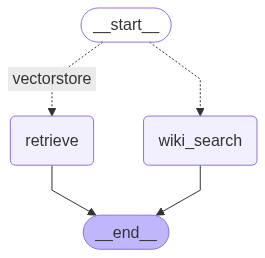

In [72]:
app

In [83]:
from pprint import pprint
# Run
inputs = {
    "question": "What is AI Agents?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final res

C:\Users\prakh\AppData\Local\Temp\ipykernel_8616\2546128898.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [76]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Avengers
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Avengers (comics)\nSummary: The Avengers are a team of superheroes appearing in American comic books published by Marvel Comics, created by writer-editor Stan Lee and artist/co-plotter Jack Kirby')
